In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost

from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import VotingRegressor, RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

In [9]:
df = pd.read_csv('./Steels_kaggle.csv')
df.head()

,Alloy code,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (°C),0.2% Proof Stress (MPa),Tensile Strength (MPa),Elongation (%),Reduction in Area (%)
0,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,27,342,490,30,71
1,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,100,338,454,27,72
2,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,200,337,465,23,69
3,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,300,346,495,21,70
4,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,400,316,489,26,79


In [10]:
X = df[[' C', ' Si', ' Mn', ' P', ' S', ' Ni', ' Cr', ' Mo',
       ' Cu', 'V', ' Al', ' N', ' Temperature (°C)']]
Y = df[' 0.2% Proof Stress (MPa)']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
Xsc_train = scaler.fit_transform(X_train)
Xsc_test = scaler.fit_transform(X_test)

In [18]:
tree = DecisionTreeRegressor(max_depth=16, max_leaf_nodes=156, min_samples_leaf=4, min_samples_split=3)
svr = SVR(kernel='rbf', C=4306, gamma=0.147368)
lr = LinearRegression()

voting = VotingRegressor(estimators=[('lr', lr), ('tree', tree), ('svc', svr)])

In [20]:
tree.fit(X_train, y_train)
svr.fit(Xsc_train, y_train)
lr.fit(Xsc_train, y_train)
voting.fit(Xsc_train, y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('tree',
                             DecisionTreeRegressor(max_depth=16,
                                                   max_leaf_nodes=156,
                                                   min_samples_leaf=4,
                                                   min_samples_split=3)),
                            ('svc', SVR(C=4306, gamma=0.147368))])

In [21]:
mse_test = mse(y_test, tree.predict(X_test), squared=False)
mse_train = mse(y_train, tree.predict(X_train), squared=False)
print("Tree: MSE for test is", mse_test, "and MSE for train is", mse_train)

mse_test = mse(y_test, lr.predict(Xsc_test), squared=False)
mse_train = mse(y_train, lr.predict(Xsc_train), squared=False)
print("LR: MSE for test is", mse_test, "and MSE for train is", mse_train)

mse_test = mse(y_test, svr.predict(Xsc_test), squared=False)
mse_train = mse(y_train, svr.predict(Xsc_train), squared=False)
print("SVR: MSE for test is", mse_test, "and MSE for train is", mse_train)

mse_test = mse(y_test, voting.predict(Xsc_test), squared=False)
mse_train = mse(y_train, voting.predict(Xsc_train), squared=False)
print("Voting: MSE for test is", mse_test, "and MSE for train is", mse_train)

Tree: MSE for test is 37.84399962455147 and MSE for train is 20.792320129620588
LR: MSE for test is 58.216495422793784 and MSE for train is 54.85495366911829
SVR: MSE for test is 30.496045588447775 and MSE for train is 19.892550651298148
Voting: MSE for test is 35.6512783864423 and MSE for train is 25.638867425456013


In [24]:
voting = VotingRegressor(estimators=[('tree', tree), ('svc', svr)])
voting.fit(Xsc_train, y_train)

mse_test = mse(y_test, voting.predict(Xsc_test), squared=False)
mse_train = mse(y_train, voting.predict(Xsc_train), squared=False)
print("Voting: MSE for test is", mse_test, "and MSE for train is", mse_train)

Voting: MSE for test is 32.9131620728943 and MSE for train is 18.24251839355702


In [32]:
model = RandomForestRegressor(max_depth=16, min_samples_leaf=4, min_samples_split=3)

params = {'n_estimators': np.arange(480, 500), 'max_leaf_nodes': np.arange(140, 160)}

grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', n_jobs=8 )
grid.fit(X_train,y_train)

grid.best_params_

{'max_leaf_nodes': 158, 'n_estimators': 496}

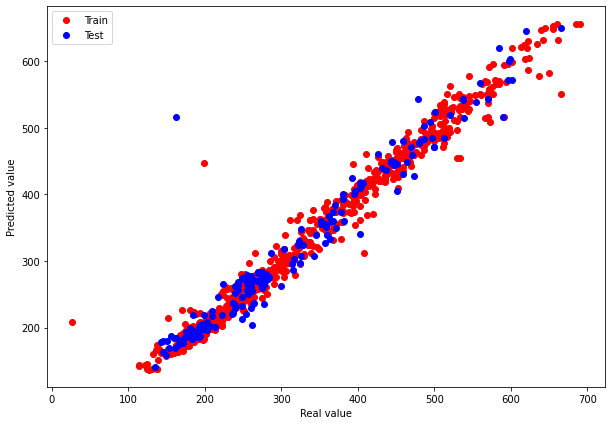

In [33]:
rndf = grid.best_estimator_

fig = plt.figure(figsize=(10,7))

plt.plot(y_train, rndf.predict(X_train), 'or', label='Train')
plt.plot(y_test, rndf.predict(X_test), 'ob', label='Test')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()

In [34]:
mse_test = mse(y_test, rndf.predict(X_test), squared=False)
mse_train = mse(y_train, rndf.predict(X_train), squared=False)
print("MSE for test is", mse_test, "and MSE for train is", mse_train)

MSE for test is 33.03355582896292 and MSE for train is 20.805981176588162


In [38]:
model = xgboost.XGBRegressor( )

params = {'max_depth': np.arange(15, 20), 'eta': np.linspace(0,1,20), 
           'num_class': np.arange(1, 5)}

grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', n_jobs=8 )
grid.fit(X_train,y_train)

grid.best_params_

/home/user/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1500 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/user/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/user/.local/lib/python3.8/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/user/.local/lib/python3.8/site-packages/xgboost/sklearn.py", line 961, in fit
    self._Booster = train(
  File "/home/user/.local/lib/python3.8/site-packages/xgboost/core

{'eta': 0.21052631578947367, 'max_depth': 15, 'num_class': 1}

In [39]:
model = xgboost.XGBRegressor( )

params = {'max_depth': np.arange(10, 16), 'eta': np.linspace(0.15,0.30, 20), 
           'num_class': np.arange(1, 3)}

grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', n_jobs=8 )
grid.fit(X_train,y_train)

grid.best_params_

/home/user/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/user/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/user/.local/lib/python3.8/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/user/.local/lib/python3.8/site-packages/xgboost/sklearn.py", line 961, in fit
    self._Booster = train(
  File "/home/user/.local/lib/python3.8/site-packages/xgboost/core.

{'eta': 0.15, 'max_depth': 10, 'num_class': 1}

In [40]:
model = xgboost.XGBRegressor( )

params = {'max_depth': np.arange(5, 10), 'eta': np.linspace(0.05,0.15, 20), 
           'num_class': np.arange(1, 3)}

grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', n_jobs=8 )
grid.fit(X_train,y_train)

grid.best_params_

/home/user/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/user/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/user/.local/lib/python3.8/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/user/.local/lib/python3.8/site-packages/xgboost/sklearn.py", line 961, in fit
    self._Booster = train(
  File "/home/user/.local/lib/python3.8/site-packages/xgboost/core.

{'eta': 0.09210526315789475, 'max_depth': 5, 'num_class': 1}

In [41]:
model = xgboost.XGBRegressor( )

params = {'max_depth': np.arange(1, 10), 'eta': np.linspace(0.03,0.1, 20), 
           'num_class': np.arange(1, 2)}

grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', n_jobs=8 )
grid.fit(X_train,y_train)

grid.best_params_

{'eta': 0.09263157894736843, 'max_depth': 5, 'num_class': 1}

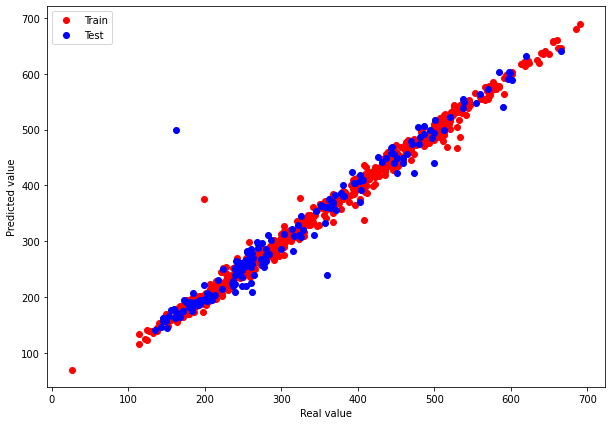

In [42]:
xgb = grid.best_estimator_

fig = plt.figure(figsize=(10,7))

plt.plot(y_train, xgb.predict(X_train), 'or', label='Train')
plt.plot(y_test, xgb.predict(X_test), 'ob', label='Test')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()

In [43]:
mse_test = mse(y_test, xgb.predict(X_test), squared=False)
mse_train = mse(y_train, xgb.predict(X_train), squared=False)
print("MSE for test is", mse_test, "and MSE for train is", mse_train)

MSE for test is 31.01216640038483 and MSE for train is 12.642608035137053


### If we compare the ensembles, then xgb gives the best result and approaches exactly the SVR. But the SVR is still in the lead. RandomForest showed itself worst of all.